In [1]:
from dotenv import load_dotenv
import os
import sys

sys.path.append('../')

load_dotenv()

config = {
    "base_url": os.getenv("BASE_URL"),
    "client_id": os.getenv("CLIENT_ID"),
    "client_secret": os.getenv("CLIENT_SECRET")
}


In [2]:
from app.agents.invoices_extractor import InvoicesExtractor, InvoiceType

extractor = InvoicesExtractor()
data = extractor.extract('2021-01-01', '2027-12-31', InvoiceType.INFLOW)


In [3]:
from app.agents.anomaly_detector import AnomalyDetector

anomaly_detector = AnomalyDetector()

output = anomaly_detector.detect(data)

In [4]:
output

DetectionOutput(anomalies=[Anomaly(date='2024-01-14', total_amount=218196.0, invoice_type='Egreso', reason='Significant increase in total amount compared to previous period.'), Anomaly(date='2024-01-24', total_amount=149039.0, invoice_type='Traslado', reason='Unusually high total amount indicating a potential anomaly.'), Anomaly(date='2024-01-24', total_amount=115423.0, invoice_type='Ingreso', reason='Notable increase in total amount compared to prior days.'), Anomaly(date='2024-11-09', total_amount=211109.0, invoice_type='Egreso', reason='Large spike in total amount suggesting an anomaly.'), Anomaly(date='2025-01-29', total_amount=220874.0, invoice_type='Traslado', reason='Significant increase in total amount relative to previous days.'), Anomaly(date='2025-08-30', total_amount=81360.6, invoice_type='Egreso', reason='Unusual rise in total amount indicating a potential anomaly.')])

In [5]:
import pandas as pd
df_anomalies = pd.DataFrame(output.model_dump()['anomalies'])

In [6]:
df_anomalies.head()

,date,total_amount,invoice_type,reason
0,2024-01-14,218196.0,Egreso,Significant increase in total amount compared ...
1,2024-01-24,149039.0,Traslado,Unusually high total amount indicating a poten...
2,2024-01-24,115423.0,Ingreso,Notable increase in total amount compared to p...
3,2024-11-09,211109.0,Egreso,Large spike in total amount suggesting an anom...
4,2025-01-29,220874.0,Traslado,Significant increase in total amount relative ...


In [7]:
df_anomalies['invoice_type']

0      Egreso
1    Traslado
2     Ingreso
3      Egreso
4    Traslado
5      Egreso
Name: invoice_type, dtype: object

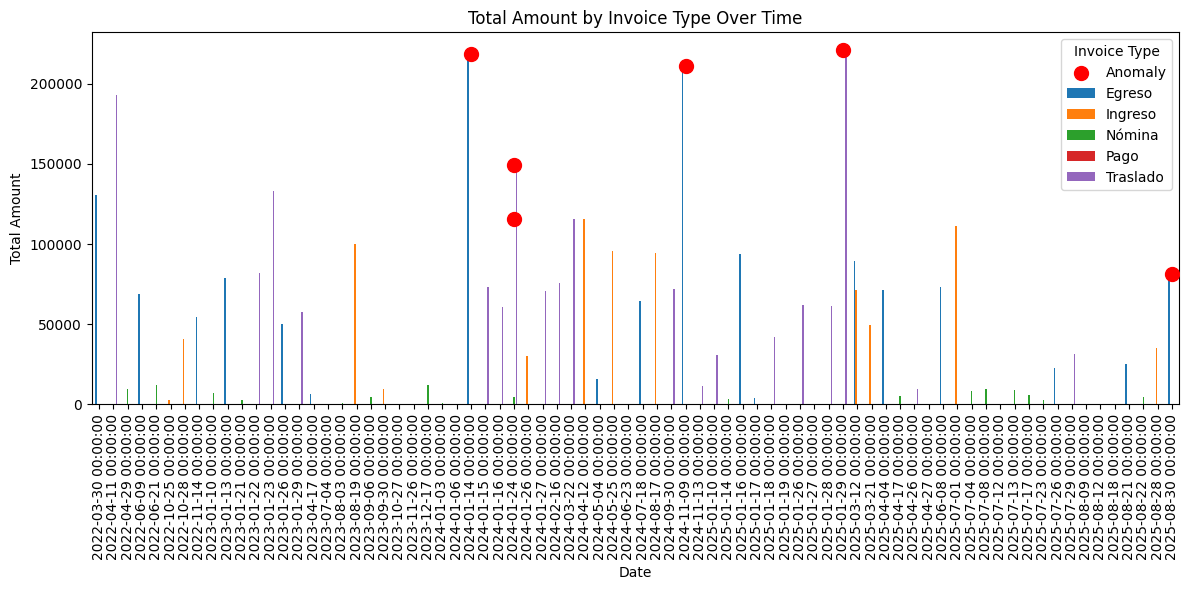

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

data['date'] = pd.to_datetime(data['date'])
pivot = data.pivot_table(index='date', columns='invoice_type', values='total_amount', aggfunc='sum')

fig, ax = plt.subplots(figsize=(12, 6))
pivot.plot(kind='bar', stacked=False, ax=ax)

# Mark anomalies with a point (avoid duplicate legend entries)
anomaly_plotted = False
if not df_anomalies.empty:
    anomaly_dates = pd.to_datetime(df_anomalies['date'])
    anomaly_amounts = df_anomalies['total_amount']
    anomaly_types = df_anomalies['invoice_type']
    for anomaly_date, anomaly_amount, anomaly_type in zip(anomaly_dates, anomaly_amounts, anomaly_types):
        if anomaly_date in pivot.index and anomaly_type in pivot.columns:
            ax.scatter(
                x=pivot.index.get_loc(anomaly_date),
                y=anomaly_amount,
                color='red',
                marker='o',
                s=100,
                label='Anomaly' if not anomaly_plotted else "",
                zorder=5
            )
            anomaly_plotted = True

# Remove duplicate 'Anomaly' from legend if present
handles, labels = ax.get_legend_handles_labels()
seen = set()
new_handles, new_labels = [], []
for h, l in zip(handles, labels):
    if l not in seen:
        new_handles.append(h)
        new_labels.append(l)
        seen.add(l)
ax.legend(new_handles, new_labels, title='Invoice Type')

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Total Amount by Invoice Type Over Time')
plt.tight_layout()
plt.show()
